# Task Overdue Classification

The task is to predict whether a request for service will be taken up ontime or not; the goal is to strike a balance between model interpretability and predictive performance; this is because this step is in our opinion more useful as a diagnostic tool to understand which are the requests at highest risk of being overdue as opposed to building a black box model for classification which yields a better performance but does not provide insight into the reasons of the prediction. We believe it is more useful to have a  

In [1]:
import pandas as pd
import numpy as np
import plotly.express as pxs
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import collections
import timeit
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import RandomSampler
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

In [2]:
os.chdir("C:\\Users\Riccardo\Documents\MIT\AEdge\AEdge_Project") 
sr=pd.read_csv("clean_311_service_requests_2019_to_2015.csv")


To create a classification model without endogeneity, one needs to get rid of either closed_dt or target_dt. Further, to separate the effects fìof the effects due to the period and those due to the amount of time a task is predicted to take, we decided to create a new set of variables:
- Year, Month, Day as separate columns for when the request was opened
- Timedelta measuring the time between when the request is opened and when it is closed

In [3]:
sr.open_dt=pd.to_datetime(sr.open_dt)
sr.target_dt=pd.to_datetime(sr.target_dt)

sr["month"]=sr.open_dt.dt.month.apply(lambda x:str(x))
sr["day"]=sr.open_dt.dt.day.apply(lambda x:str(x))
sr["hour"]=sr.open_dt.dt.hour.apply(lambda x:str(x))
sr["week"]=sr.open_dt.dt.week.apply(lambda x:str(x))
 
sr["ttc"]=sr.target_dt-sr.open_dt #target time to close
sr["ttc"]=sr.ttc.apply(lambda x: x.total_seconds()/3600) #tranform in number of hours


#sr["year"]=sr.open_dt.dt.year.apply(lambda x:str(x))

In [11]:
import re
sr.ward=sr.ward.apply(lambda x: str(re.findall("\d+|$",str(x))[0]))
sr.ward=sr.ward.apply(lambda x: "0"+x if len(x)<=1 else x)
sr.ward=sr.ward.apply(lambda x: "nan" if (x=="0" or x=="" or x=="00") else x)

In [13]:
sum(pd.isnull(sr.ttc))==sum(pd.isnull(sr.target_dt)) #check no overflow using total seconds

True

Check variable types and number of uniques\

In [14]:
sr.dtypes;

In [15]:
cols=sr.columns
for col in cols:
    if (sr.dtypes[col]!="float64" and sr.dtypes[col]!="int64"):
        print(col, " has unique levels", len(sr[col].unique()))

open_dt  has unique levels 1063610
target_dt  has unique levels 642021
closed_dt  has unique levels 1071545
case_status  has unique levels 2
case_title  has unique levels 13704
subject  has unique levels 14
reason  has unique levels 52
type  has unique levels 194
queue  has unique levels 185
department  has unique levels 17
fire_district  has unique levels 13
pwd_district  has unique levels 23
city_council_district  has unique levels 12
police_district  has unique levels 25
neighborhood  has unique levels 25
neighborhood_services_district  has unique levels 18
ward  has unique levels 23
precinct  has unique levels 256
location_street_name  has unique levels 127111
source  has unique levels 7
month  has unique levels 12
day  has unique levels 31
hour  has unique levels 24
week  has unique levels 53


Now we can create the final dataset;

In [16]:
sr=sr.dropna(subset=["ontime"])#, "year"])
df=sr.drop(columns=[#drop open_dt and target_dt because information is already captured by the other variables
                    "open_dt", "target_dt",
                    #drop closed_dt because it's what we are trying to predict 
                     "closed_dt",
                    #drop because it's the index
                    "case_enquiry_id", 
                    #drop because of excessive number of levels
                    "location_street_name","case_title",
                    #drop because it's not accurate
                    "case_status",
                    #drop because it's not ordinal and redundant ??
                     "latitude","longitude",
                    # drop  because they are too granular
                    "queue","type","precinct","location_zipcode"])

df=df.dropna() #drop everything with NAs


In [17]:
df=df.sample(300000)
df

,ontime,subject,reason,department,fire_district,pwd_district,city_council_district,police_district,neighborhood,neighborhood_services_district,ward,source,month,day,hour,week,ttc
426108,0,Transportation - Traffic Division,Signs & Signals,INFO,8,07,5,B3,Greater Mattapan,9,18,Constituent Call,8,8,6,32,24.001667
1136081,0,Transportation - Traffic Division,Signs & Signals,BTDT,7,03,7,B2,Roxbury,13,08,Constituent Call,8,25,9,35,24.003611
1166971,1,Public Works Department,Street Cleaning,PWDx,7,03,3,C11,Dorchester,8,15,City Worker App,10,18,8,42,48.274722
377234,1,Parks & Recreation Department,Trees,PARK,4,10A,7,D4,Fenway / Kenmore / Audubon Circle / Longwood,13,04,Employee Generated,6,4,11,23,8760.017500
1038786,0,Public Works Department,Street Cleaning,PWDx,4,10A,8,D4,Back Bay,14,05,Constituent Call,2,20,21,8,107.314722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061864,1,Public Works Department,Recycling,PWDx,12,08,5,E18,Hyde Park,10,18,Constituent Call,3,27,14,13,1487.993333
69879,0,Public Works Department,Highway Maintenance,PWDx,4,1C,8,D4,Back Bay,14,05,Citizens Connect App,4,14,11,15,68.900000
585227,1,Public Works Department,Code Enforcement,PWDx,11,04,9,D14,Allston / Brighton,15,22,Constituent Call,3,29,16,13,48.011667
394422,1,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,BTDT,1,09,1,A7,East Boston,1,01,Citizens Connect App,6,26,18,26,38.323333


Use one hot encoding on the following list of variables:

In [19]:
cols=list(df.columns)
cols

['ontime',
 'subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'month',
 'day',
 'hour',
 'week',
 'ttc']

In [20]:
cols=list(df.columns)
cols.remove("ontime")
categorical_variables=[]
numerical_variables=[]
for col in cols:
    if (df.dtypes[col]!="float64" and df.dtypes[col]!="timedelta64[ns]"):
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

In [21]:
categorical_variables

['subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'month',
 'day',
 'hour',
 'week']

To make levels more interpretable, I got rid of the levels which do not appear frequently (less than 1% of the observations)

In [22]:
#run only once
def cut_levels(df, var, treshold):
    value_counts = df[var].value_counts()
    labels = value_counts.index[(value_counts/sum(value_counts))<treshold]
    df[var][df[var].isin(labels)] = "other"
    df.drop(columns=var)
    return df[var]


for var in categorical_variables:
    print(var)
    cut_levels(df, var, 0.01)
    print(df[var].unique())      

subject
['Transportation - Traffic Division' 'Public Works Department'
 'Parks & Recreation Department' 'Inspectional Services'
 'Property Management' "Mayor's 24 Hour Hotline" 'other']
reason


<ipython-input-22-33ddc2cd64d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][df[var].isin(labels)] = "other"


['Signs & Signals' 'Street Cleaning' 'Trees' 'Recycling'
 'Highway Maintenance' 'Sanitation' 'Code Enforcement' 'Housing'
 'Enforcement & Abandoned Vehicles' 'Graffiti' 'Environmental Services'
 'Street Lights' 'Park Maintenance & Safety' 'other' 'Building'
 'Employee & General Comments']
department
['INFO' 'BTDT' 'PWDx' 'PARK' 'ISD' 'PROP' 'other']
fire_district
['8' '7' '4' '3' '12' '6' '1' '9' '11' ' ' 'other']
pwd_district
['07' '03' '10A' '1C' '1B' '08' '05' '09' '1A' '02' '04' '10B' '06' ' '
 'other']
city_council_district
['5' '7' '3' '8' '1' '2' '6' '9' '4' ' ' 'other']
police_district
['B3' 'B2' 'C11' 'D4' 'A1' 'E18' 'C6' 'A7' 'A15' 'E13' 'D14' 'E5' ' '
 'other']
neighborhood
['Greater Mattapan' 'Roxbury' 'Dorchester'
 'Fenway / Kenmore / Audubon Circle / Longwood' 'Back Bay'
 'Downtown / Financial District' 'South End' 'Roslindale' 'Beacon Hill'
 'South Boston / South Boston Waterfront' 'East Boston' 'Charlestown'
 'Jamaica Plain' 'Allston / Brighton' 'Hyde Park' 'West Roxbur

Define train test splits

In [23]:
#time based (not used because it doesn't work)
def split_time(df):
    #calculate proportions to make sure the split is consistent
    prop1=df[df["year"]=="2019"][df["ontime"]==1].shape[0]/df[df['year']=="2019"].shape[0]
    prop2=df[df['year']=="2018"][df["ontime"]==1].shape[0]/df[df['year']=="2018"].shape[0]
    prop3=df[df['year']<"2018"][df["ontime"]==1].shape[0]/df[df['year']<"2018"].shape[0]
    #print out results
    print("Test proportion: {}\tValidation proportion: {}\tTrain proportion: {}".format(prop1,prop2,prop3))
    pm=((prop1+prop2+prop3)/3)
    if (abs(prop1-pm) >.2 or abs(prop1-pm) >.2 or abs(prop1-pm) >.2):
        print("WARNING: TIME BASED SPLIT MISLEADING")
    
    X_test, y_test = df[df['year']=="2019"].drop(columns="ontime"), df[df['year']=="2019"]["ontime"]
    X_valid, y_valid = df[df['year']=="2018"].drop(columns="ontime"), df[df['year']=="2018"]["ontime"]
    X_train, y_train = df[df['year']<"2018"].drop(columns="ontime"), df[df['year']<"2018"]["ontime"]
    X_trainval, y_trainval= df[df['year']<"2019"].drop(columns="ontime"), df[df['year']<"2019"]["ontime"]

    X_test = X_test.drop(['year'], axis = 1)
    X_valid = X_valid.drop(['year'], axis = 1)
    X_train = X_train.drop(['year'], axis = 1)
    X_trainval = X_trainval.drop(['year'], axis = 1)
    
    return X_train, X_valid, X_test, y_train, X_trainval, y_trainval, y_valid, y_test

Use stratified sampling because it's better for calssification purposes

In [24]:
#stratified
def split(X_processed, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_processed, y, stratify=y, test_size=0.2,random_state=500)

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2,random_state=500)
    return X_train, X_val, X_test, y_train, X_trainval, y_trainval, y_val, y_test

In [25]:
X=df.drop(columns=["ontime"])
y=df["ontime"]
X_train, X_valid, X_test, y_train, X_trainval, y_trainval, y_valid, y_test=split(X,y)

Export the dataframe in Julia for OCT modelling

In [26]:
X_trainval.to_csv("X_trainval.csv")
X_test.to_csv("X_test.csv")

y_test.to_csv("y_test.csv")
y_trainval.to_csv("y_trainval.csv")

Create a pipeline to fit classic ML algorihtms. Since the problem of interpretability is very relevant, we chose to prioritize it over performance. For this reason, we fit a CART model alongside other ensemble classification methods to benchmark performance. In order to maximise interpretability, we first chose to encode the variables through one hot encode

In [27]:
categorical_variables

['subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'month',
 'day',
 'hour',
 'week']

In [28]:
def encoder(X,y, categorical_variables,numerical_variables):
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
    numerical_imputer= SimpleImputer(strategy='mean')
    X_preprocessor = ColumnTransformer(
        transformers=[('cat', categorical_transformer, categorical_variables), ('num', numerical_imputer, numerical_variables)])
    
    X_processed = X_preprocessor.fit_transform(X)
    col_list=X_preprocessor.transformers_[0][1].named_steps['onehot'].get_feature_names(categorical_variables) 
    #df_processed
    #df_processed=pd.DataFrame(df_processed)
    #df_processed.columns=list(col_list) + numerical_variables +["ontime","year"]
    #data_coll = collections.namedtuple('data', ['X', 'X_processed'])
    #data_processed = data_coll(X, X_processed)

    return X_processed,y ,list(col_list)+ numerical_variables 

Finally, we fit a validated CART model

In [29]:
def CART(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials):
        
    start = timeit.default_timer()
    def objective(trial):
        # Maximum number of levels in tree
        CART_max_depth = trial.suggest_int("CART_max_depth", 3, 7)
        
        ## Minimum number of samples required to split a node
        CART_minbucket = trial.suggest_int("CART_min_bucket", 40, 70)
        
        # Minimum decrease in impurity required for split to happen
        CART_cp = trial.suggest_loguniform("CART_cp", 0.001, 0.1)

        classifier_obj = DecisionTreeClassifier(
            min_impurity_decrease=CART_cp, max_depth=CART_max_depth)
        score = cross_val_score(classifier_obj, X_val, y_val, n_jobs=-1, cv=3)
        accuracy = score.mean()
        return accuracy

    study_CART = optuna.create_study(sampler = RandomSampler(seed=1), direction='maximize')
    study_CART.optimize(objective, n_trials=n_trials)
    
    best_cp= study_CART.best_params['CART_cp']
    best_max_depth = study_CART.best_params['CART_max_depth']
    
    final_CART = DecisionTreeClassifier(
            min_impurity_decrease=best_cp, max_depth=best_max_depth)
    final_CART.fit(X_trainval,y_trainval)
    stop = timeit.default_timer()
    print("time required is:", round((stop-start)/60,2))
    return final_CART

Run the full pipeline for CART

In [318]:
a,b,c=encoder(df.drop(columns=["ontime"]),df["ontime"],categorical_variables,numerical_variables)

In [322]:
categorical_variables

['subject',
 'reason',
 'department',
 'fire_district',
 'pwd_district',
 'city_council_district',
 'police_district',
 'neighborhood',
 'neighborhood_services_district',
 'ward',
 'source',
 'month',
 'day',
 'hour',
 'week']

In [364]:
X.iloc[:,9]

369571       other
400175       other
668594     Ward 22
1200456     Ward 3
879858       other
            ...   
516891     Ward 18
825475       other
576105     Ward 22
1075990     Ward 5
379027      Ward 2
Name: ward, Length: 300000, dtype: object

In [30]:
def full_pipeline(df,categorical_variables,numerical_variables,n_trials):
    
    X=df.drop(columns=["ontime"])
    y=df["ontime"]
    
    X_processed,y, col_list= encoder(X,y, categorical_variables,numerical_variables)
    print("encoder completed; starting splits\n")
    
    X_train, X_val, X_test, y_train, X_trainval, y_trainval, y_val, y_test=split(X_processed,y)
    
    print("split completed; starting validation\n")
    final_CART=CART(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials)
    print("pipeline completed!")
    return final_CART, X_trainval, X_test, y_trainval,y_test, col_list

final_CART, X_trainval_enc, X_test_enc, y_trainval_enc, y_test_enc, col_list_enc =full_pipeline(df,categorical_variables,numerical_variables,10)

encoder completed; starting splits



[I 2020-11-14 12:58:21,462] A new study created in memory with name: no-name-fd21b735-c01c-40de-8084-d7bdf9720ccd


split completed; starting validation



[I 2020-11-14 12:58:24,502] Trial 0 finished with value: 0.766 and parameters: {'CART_max_depth': 6, 'CART_min_bucket': 52, 'CART_cp': 0.07330181339535059}. Best is trial 0 with value: 0.766.
[I 2020-11-14 12:58:26,475] Trial 1 finished with value: 0.766 and parameters: {'CART_max_depth': 4, 'CART_min_bucket': 51, 'CART_cp': 0.099559115738444}. Best is trial 0 with value: 0.766.
[I 2020-11-14 12:58:27,993] Trial 2 finished with value: 0.8098125 and parameters: {'CART_max_depth': 3, 'CART_min_bucket': 56, 'CART_cp': 0.006210998932353835}. Best is trial 2 with value: 0.8098125.
[I 2020-11-14 12:58:28,934] Trial 3 finished with value: 0.766 and parameters: {'CART_max_depth': 7, 'CART_min_bucket': 46, 'CART_cp': 0.07431528396574373}. Best is trial 2 with value: 0.8098125.
[I 2020-11-14 12:58:30,983] Trial 4 finished with value: 0.8243541666666667 and parameters: {'CART_max_depth': 7, 'CART_min_bucket': 70, 'CART_cp': 0.004232013397179603}. Best is trial 4 with value: 0.8243541666666667.
[I

time required is: 0.4
pipeline completed!


In [32]:
X_trainval_enc.shape

(240000, 262)

In [ ]:
def full_pipeline(df,categorical_variables,numerical_variables,n_trials):
    X_train, X_val, X_test, y_train, X_trainval, y_trainval, y_val, y_test=split(df_processed)
    print("split completed; starting validation\n")
    
    final_CART=CART(X_train, X_val, y_train, y_val, X_trainval, y_trainval, n_trials)
    print("pipeline completed!")
    return final_CART, X_trainval, X_test, y_trainval,y_test, col_list

final_CART, X_trainval_enc, X_test_enc, y_trainval_enc,y_test_enc, col_list_enc =full_pipeline(df,categorical_variables,numerical_variables,10)

Get final scores

In [336]:
X_trainval_enc
#y_scores=final_CART.predict_proba(X_test_enc)[:,1]

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  86.11555556],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 408.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  24.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 335.99972222],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  66.16194444],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,  38.10805556]])

In [33]:
print("Train Accuracy score: {}\tTest Accurarcy score: {}".format(
        final_CART.score(X_trainval_enc, y_trainval_enc),
        final_CART.score(X_test_enc, y_test_enc)))

y_prob_cart=final_CART.predict_proba(X_test_enc)[:,1]
auc_cart=roc_auc_score(y_test, y_prob_cart)
print("Test ROC-AUC score: {}".format(auc_cart))

Train Accuracy score: 0.8232458333333333	Test Accurarcy score: 0.8224833333333333
Test ROC-AUC score: 0.8022045045518179


Plot the final tree

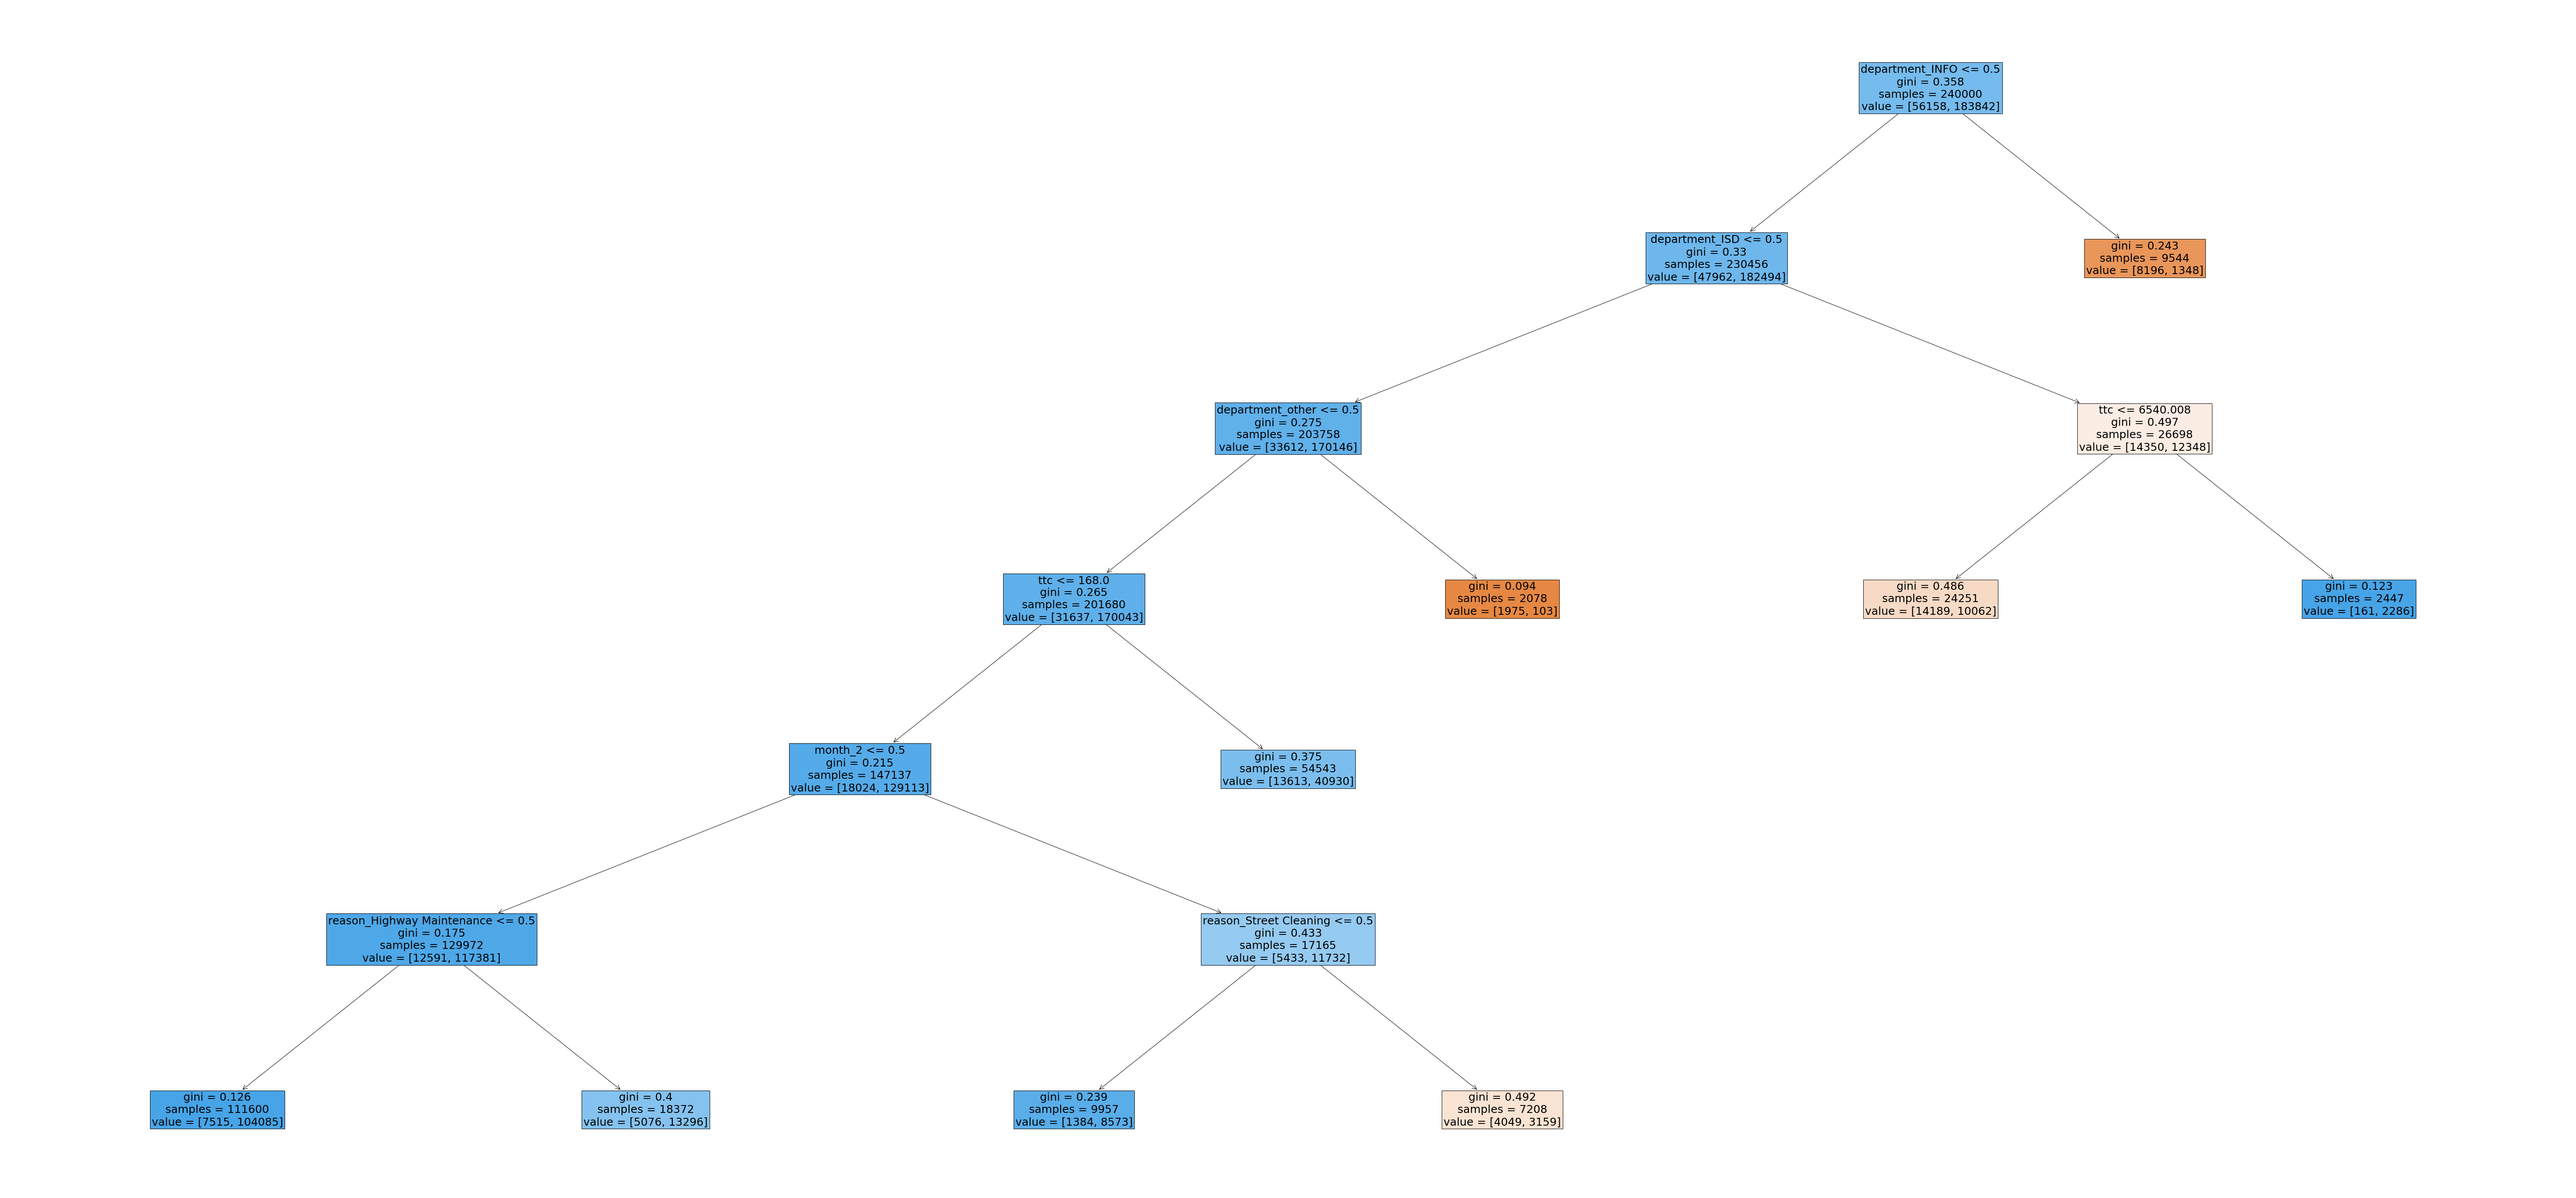

In [38]:
import matplotlib.pyplot as plt
from sklearn import tree
fig = plt.figure(figsize=(105,50))
plot= tree.plot_tree(final_CART, feature_names=col_list_enc,fontsize=25,
                   filled=True)

In order to get an upper bound of performance for the black box model we used CatBoost, which is a categorical method well known for its ability to deal with categorical variables.

##  Cat Boost

The model is fit with the same split fed to the OCT, since there is no need for one-hot encoding. We don't perform validation because of the computational limitations and because the standard parameters of CatBoost Classifiers tend to be already very good.

In [40]:
cb_model = CatBoostClassifier(iterations = 200, eval_metric='AUC')

cb_model.fit(X_train, y_train,
             eval_set=(X_valid,y_valid),
             cat_features=categorical_variables,#column_index(X_train,categorical_features_names),
             use_best_model=True,
             verbose=True)

Learning rate set to 0.316144
0:	test: 0.7420372	best: 0.7420372 (0)	total: 373ms	remaining: 36.9s
1:	test: 0.7664937	best: 0.7664937 (1)	total: 519ms	remaining: 25.4s
2:	test: 0.7687893	best: 0.7687893 (2)	total: 624ms	remaining: 20.2s
3:	test: 0.8160464	best: 0.8160464 (3)	total: 727ms	remaining: 17.4s
4:	test: 0.8265692	best: 0.8265692 (4)	total: 831ms	remaining: 15.8s
5:	test: 0.8482611	best: 0.8482611 (5)	total: 948ms	remaining: 14.9s
6:	test: 0.8514615	best: 0.8514615 (6)	total: 1.05s	remaining: 14s
7:	test: 0.8542053	best: 0.8542053 (7)	total: 1.15s	remaining: 13.2s
8:	test: 0.8556429	best: 0.8556429 (8)	total: 1.3s	remaining: 13.1s
9:	test: 0.8557134	best: 0.8557134 (9)	total: 1.39s	remaining: 12.6s
10:	test: 0.8587130	best: 0.8587130 (10)	total: 1.49s	remaining: 12s
11:	test: 0.8605764	best: 0.8605764 (11)	total: 1.59s	remaining: 11.7s
12:	test: 0.8637409	best: 0.8637409 (12)	total: 1.7s	remaining: 11.4s
13:	test: 0.8651567	best: 0.8651567 (13)	total: 1.8s	remaining: 11.1s
14:

In [ ]:
cb_model = CatBoostClassifier(iterations = 100,depth=16, eval_metric='AUC')
catboost_pool = Pool(X_train, y_train,cat_features=categorical_variables)
cb_model.fit(catboost_pool,
             eval_set=(X_valid,y_valid),
             #column_index(X_train,categorical_features_names),
             use_best_model=True,
             verbose=True)

Learning rate set to 0.316144
0:	test: 0.8124473	best: 0.8124473 (0)	total: 817ms	remaining: 1m 20s
1:	test: 0.8203132	best: 0.8203132 (1)	total: 1.09s	remaining: 53.7s
2:	test: 0.8299732	best: 0.8299732 (2)	total: 3.21s	remaining: 1m 43s
3:	test: 0.8465501	best: 0.8465501 (3)	total: 5.59s	remaining: 2m 14s
4:	test: 0.8768755	best: 0.8768755 (4)	total: 7.99s	remaining: 2m 31s
5:	test: 0.8848303	best: 0.8848303 (5)	total: 10.2s	remaining: 2m 40s
6:	test: 0.8887025	best: 0.8887025 (6)	total: 12.1s	remaining: 2m 41s
7:	test: 0.8909431	best: 0.8909431 (7)	total: 14s	remaining: 2m 40s
8:	test: 0.8908063	best: 0.8909431 (7)	total: 14.1s	remaining: 2m 22s
9:	test: 0.8929561	best: 0.8929561 (9)	total: 16.1s	remaining: 2m 25s
10:	test: 0.8940517	best: 0.8940517 (10)	total: 18s	remaining: 2m 25s


In [43]:
y_pred_cb = cb_model.predict_proba(X_test)[:,1]
auc_cb=roc_auc_score(y_test, y_pred_cb)
print("AUC Cat Boost is: ", auc_cb)

AUC Cat Boost is:  0.8871325495446833


In [44]:
importance, col_names=list(cb_model.feature_importances_),list(X_train.columns)
data={"imp":importance, "col_names":col_names}
feature_imp=pd.DataFrame(data)

The feature importance graph is quite consistent with the CART and OCT models, although less specific.

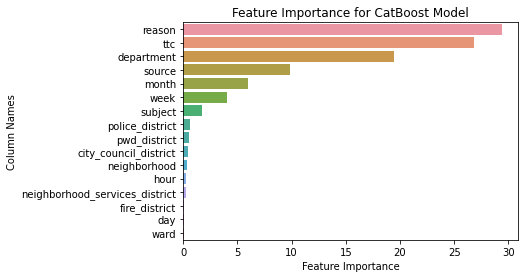

In [46]:
import seaborn as sns
plt.figure()
sns.barplot(data=feature_imp.sort_values(by="imp", ascending=False), x="imp",y="col_names")
plt.xlabel('Feature Importance')
plt.ylabel('Column Names')
plt.title('Feature Importance for CatBoost Model')
plt.show()

In [47]:
#validate catboost ??

In [54]:
y_oct =pd.read_csv("ROC_OCT.csv") #it is important that the script for OCT is run on the same data exported 
                                  #from this noteboook to get comparable results 
y_oct=y_oct.iloc[:,1]
auc_oct=roc_auc_score(y_test, y_oct)
print("AUC OCT is: ", auc_oct)

AUC OCT is:  0.8253409004654173


To get a better idea of the performance of the three models we plot a ROC curve; as expected, the black box benchmark achieves a better performance; nonetheless, both OCT and CART do quite well themeselves.  

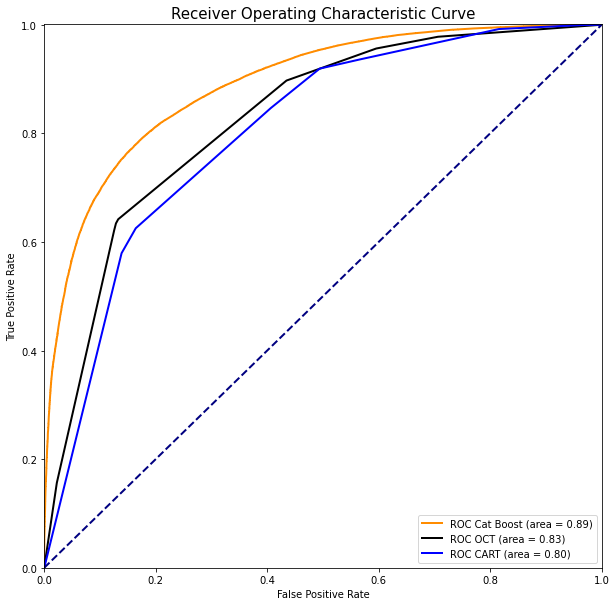

In [55]:
plt.figure(figsize=(10,10))
lw = 2
catboost_pool = Pool(X_train, y_train,cat_features=categorical_variables)
(fpr, tpr, thresholds) = get_roc_curve(cb_model,catboost_pool)


plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC Cat Boost (area = %0.2f)' % auc_cb)

(fpr_OCT, tpr_OCT, thresholds_OCT)=roc_curve(y_test, y_oct)
plt.plot(fpr_OCT, tpr_OCT, color='black'
         ,lw=lw, label='ROC OCT (area = %0.2f)'%auc_oct)

(fpr_cart, tpr_cart, thresholds_cart) = roc_curve(y_test, y_prob_cart, pos_label=1)
plt.plot(fpr_cart, tpr_cart, color='blue',lw=lw, label='ROC CART (area = %0.2f)' % auc_cart)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.001])
plt.ylim([0.0, 1.001])

         
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend(loc="lower right")
plt.show()